<a href="https://colab.research.google.com/github/iSanjayYadava/ColabNotebooks/blob/master/004_callbacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/ColabNotebooks/')
from nb_003 import *

In [0]:
#export
#from nb_003 import *
from torch import Tensor,tensor
from fastprogress import master_bar,progress_bar
from fastprogress.fastprogress import MasterBar, ProgressBar
import re
from typing import Iterator

Floats = Union[float, Collection[float]]
PBar = Union[MasterBar, ProgressBar]

In [0]:
import fastprogress.fastprogress as fp2

# Hyperparameters and callbacks

## Setup

In [0]:
DATA_PATH = Path('/content/gdrive/My Drive/ColabNotebooks/data')
PATH = DATA_PATH/'cifar10_dog_air'

data_mean,data_std = map(tensor, ([0.491, 0.482, 0.447], [0.247, 0.243, 0.261]))
cifar_norm,cifar_denorm = normalize_funcs(data_mean,data_std)

tfms = [flip_lr(p=0.5),
        pad(padding=4),
        crop(size=32, row_pct=(0,1.), col_pct=(0,1.))]

bs = 64

In [11]:
train_ds = ImageDataset.from_folder(PATH/'train', classes=['airplane','dog'])
valid_ds = ImageDataset.from_folder(PATH/'test', classes=['airplane','dog'])
data = DataBunch.create(train_ds, valid_ds, bs=bs, train_tfm=tfms, num_workers=4, dl_tfms=cifar_norm)
len(data.train_dl), len(data.valid_dl)

(129, 4)

In [0]:
model = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=16)

## Setting hyperparameters easily

We want an optimizer with an easy way to set hyperparameters: they're all properties and we define custom setters to handle the different names in pytorch optimizers. We will define a Wrapper for all optimizers within which we will define each parameter's setter functions for setting the values we want. This will allow us to set a default value for each hyperparameter but to also easily edit it while experimenting. 

In [0]:
#export
class OptimWrapper():
    "Normalize naming of parameters on wrapped optimizers"
    def __init__(self, opt:optim.Optimizer, wd:float=0., true_wd:bool=False):
        "Create wrapper for `opt` and optionally (`true_wd`) set weight decay `wd`"
        self.opt,self.true_wd = opt,true_wd
        self.opt_keys = list(self.opt.param_groups[0].keys())
        self.opt_keys.remove('params')
        self.read_defaults()
        self._wd = wd
    
    #Pytorch optimizer methods
    def step(self)->None:
        "Performs a single optimization step "
        # weight decay outside of optimizer step (AdamW)
        if self.true_wd:
            for pg in self.opt.param_groups:
                for p in pg['params']: p.data.mul_(1 - self._wd*pg['lr'])
            self.set_val('weight_decay', 0)
        self.opt.step()
    
    def zero_grad(self)->None: 
        "Clears the gradients of all optimized `Tensor`s"
        self.opt.zero_grad()
    
    #Hyperparameters as properties
    @property
    def lr(self)->float: 
        "Learning rate"
        return self._lr

    @lr.setter
    def lr(self, val:float)->None: self._lr = self.set_val('lr', val)
    
    @property
    def mom(self)->float: 
        "Momentum if present on wrapped opt, else betas"
        return self._mom

    @mom.setter
    def mom(self, val:float)->None:
        "Momentum if present on wrapped opt, else betas"
        if 'momentum' in self.opt_keys: self.set_val('momentum', val)
        elif 'betas' in self.opt_keys:  self.set_val('betas', (val, self._beta))
        self._mom = val
    
    @property
    def beta(self)->float:
        "Beta if present on wrapped opt, else it's alpha"
        return self._beta

    @beta.setter
    def beta(self, val:float)->None:
        "Beta if present on wrapped opt, else it's alpha"
        if 'betas' in self.opt_keys:    self.set_val('betas', (self._mom,val))
        elif 'alpha' in self.opt_keys:  self.set_val('alpha', val)
        self._beta = val
    
    @property
    def wd(self)->float: 
        "Weight decay for wrapped opt"
        return self._wd

    @wd.setter
    def wd(self, val:float)->None:
        "Weight decay for wrapped opt"
        if not self.true_wd: self.set_val('weight_decay', val)
        self._wd = val
    
    #Helper functions
    def read_defaults(self):
        "Reads in the default params from the wrapped optimizer"
        self._beta = None
        if 'lr' in self.opt_keys: self._lr = self.opt.param_groups[0]['lr']
        if 'momentum' in self.opt_keys: self._mom = self.opt.param_groups[0]['momentum']
        if 'alpha' in self.opt_keys: self._beta = self.opt.param_groups[0]['alpha']
        if 'betas' in self.opt_keys: self._mom,self._beta = self.opt.param_groups[0]['betas']
        if 'weight_decay' in self.opt_keys: self._wd = self.opt.param_groups[0]['weight_decay']
    
    def set_val(self, key:str, val:Any):
        "Set parameter on wrapped optimizer"
        for pg in self.opt.param_groups: pg[key] = val
        return val

In [14]:
opt_fn = partial(optim.Adam, betas=(0.95,0.99))
opt = OptimWrapper(opt_fn(model.parameters(), 1e-2))
opt.lr, opt.mom, opt.wd, opt.beta

(0.01, 0.95, 0.0, 0.99)

In [15]:
opt.lr=0.2
opt.lr, opt.mom, opt.wd, opt.beta

(0.2, 0.95, 0.0, 0.99)

## Callbacks

Now that it's easy to set and change the HP in the optimizer, we need a scheduler to change it. To keep the training loop as readable as possible we don't want to handle all of this stuff inside it so we'll use callbacks. 

In [0]:
#export
class Callback():
    "Base class for callbacks that want to record values, dynamically change learner params, etc"
    def on_train_begin(self, **kwargs:Any)->None:         
        "To initialize constants in the callback."
        pass
    def on_epoch_begin(self, **kwargs:Any)->None:
        "At the beginning of each epoch"
        pass
    def on_batch_begin(self, **kwargs:Any)->None: 
        """To set HP before the step is done.
           Returns xb, yb (which can allow us to modify the input at that step if needed)"""
        pass
    def on_loss_begin(self, **kwargs:Any)->None:
        """Called after the forward pass but before the loss has been computed.
           Returns the output (which can allow us to modify it)"""
        pass
    def on_backward_begin(self, **kwargs:Any)->None:
        """Called after the forward pass and the loss has been computed, but before the back propagation.
           Returns the loss (which can allow us to modify it, for instance for reg functions)"""
        pass
    def on_backward_end(self, **kwargs:Any)->None:
        """Called after the back propagation had been done (and the gradients computed) but before the step of the optimizer.
           Useful for true weight decay in AdamW"""
        pass
    def on_step_end(self, **kwargs:Any)->None:
        "Called after the step of the optimizer but before the gradients are zeroed (not sure this one is useful)"
        pass
    def on_batch_end(self, **kwargs:Any)->None:
        "Called at the end of the batch"
        pass
    def on_epoch_end(self, **kwargs:Any)->bool:
        "Called at the end of an epoch"
        return False
    def on_train_end(self, **kwargs:Any)->None:
        "Useful for cleaning up things and saving files/models"
        pass

To be more convenient and make the code of the training loop cleaner, we'll create a class to handle the callbacks. It will keep track of everything the training loop sends it, then pack it in the kwargs of each callback. This way, all the callbacks can access things like the epoch number, the last loss etc... Notice also that callbacks that are given a parameter have the opportunity to edit that parameter and return a new value.

Helper class that computes a moving average of the values sent to it. Will be useful for the smooth_loss but can smoothen anything.

In [0]:
#export
class SmoothenValue():
    "Creates a smooth moving average for a value (loss, etc)"
    def __init__(self, beta:float)->None:
        "Create smoother for value, beta should be 0<beta<1"
        self.beta,self.n,self.mov_avg = beta,0,0
    
    def add_value(self, val:float)->None:
        "Add current value to calculate updated smoothed value "
        self.n += 1
        self.mov_avg = self.beta * self.mov_avg + (1 - self.beta) * val
        self.smooth = self.mov_avg / (1 - self.beta ** self.n)

In [0]:
#export
TensorOrNumber = Union[Tensor,Number]
CallbackList = Collection[Callback]
MetricsList = Collection[TensorOrNumber]
TensorOrNumList = Collection[TensorOrNumber]
MetricFunc = Callable[[Tensor,Tensor],TensorOrNumber]
MetricFuncList = Collection[MetricFunc]


def _get_init_state(): return {'epoch':0, 'iteration':0, 'num_batch':0}

@dataclass
class CallbackHandler():
    "Manages all of the registered callback objects, beta is for smoothing loss"
    callbacks:CallbackList
    beta:float=0.98
        
    def __post_init__(self)->None:
        "InitInitializeitialize smoother and learning stats"
        self.smoothener = SmoothenValue(self.beta)
        self.state_dict:Dict[str,Union[int,float,Tensor]]=_get_init_state()
    
    def __call__(self, cb_name, **kwargs)->None:
        "Call through to all of the callback handlers"
        return [getattr(cb, f'on_{cb_name}')(**self.state_dict, **kwargs) for cb in self.callbacks]
    
    def on_train_begin(self, epochs:int, pbar:PBar, metrics:MetricFuncList)->None:
        "About to start learning"
        self.state_dict = _get_init_state()
        self.state_dict['n_epochs'],self.state_dict['pbar'],self.state_dict['metrics'] = epochs,pbar,metrics
        self('train_begin')
        
    def on_epoch_begin(self)->None: 
        "Handle new epoch"
        self.state_dict['num_batch'] = 0
        self('epoch_begin')
        
    def on_batch_begin(self, xb:Tensor, yb:Tensor)->None:
        "Handle new batch `xb`,`yb`"
        self.state_dict['last_input'], self.state_dict['last_target'] = xb, yb
        for cb in self.callbacks:
            a = cb.on_batch_begin(**self.state_dict)
            if a is not None: self.state_dict['last_input'], self.state_dict['last_target'] = a
        return self.state_dict['last_input'], self.state_dict['last_target']
    
    def on_loss_begin(self, out:Tensor)->None:
        "Handle start of loss calculation with model output `out`"
        self.state_dict['last_output'] = out
        for cb in self.callbacks:
            a = cb.on_loss_begin(**self.state_dict)
            if a is not None: self.state_dict['last_output'] = a
        return self.state_dict['last_output']
    
    def on_backward_begin(self, loss:Tensor)->None:
        "Handle gradient calculation on `loss`"
        self.smoothener.add_value(loss.detach())
        self.state_dict['last_loss'], self.state_dict['smooth_loss'] = loss, self.smoothener.smooth
        for cb in self.callbacks:
            a = cb.on_backward_begin(**self.state_dict)
            if a is not None: self.state_dict['last_loss'] = a
        return self.state_dict['last_loss']
    
    def on_backward_end(self)->None:  
        "Handle end of gradient calc"
        self('backward_end')
    def on_step_end(self)->None:   
        "Handle end of optimization step"
        self('step_end')
        
    def on_batch_end(self, loss:Tensor)->None:
        "Handle end of processing one batch with `loss`"
        self.state_dict['last_loss'] = loss
        stop = np.any(self('batch_end'))
        self.state_dict['iteration'] += 1
        self.state_dict['num_batch'] += 1
        return stop
    
    def on_epoch_end(self, val_metrics:MetricsList)->bool:
        "Epoch is done, process `val_metrics`"
        self.state_dict['last_metrics'] = val_metrics
        stop = np.any(self('epoch_end'))
        self.state_dict['epoch'] += 1
        return stop
    
    def on_train_end(self, exception:Union[bool,Exception])->None: 
        "Handle end of training, `exception` is an `Exception` or False if no exceptions during training"
        self('train_end', exception=exception)

The idea is to have a callback handler between every line of the training loop, that way every callback we need to add will be treated there and not inside. We also add metrics right after calculating the loss.

In [0]:
#export

OptMetrics = Optional[Collection[Any]]
OptLossFunc = Optional[LossFunction]
OptCallbackHandler = Optional[CallbackHandler]
OptOptimizer = Optional[optim.Optimizer]
OptCallbackList = Optional[CallbackList]


def loss_batch(model:Model, xb:Tensor, yb:Tensor, loss_fn:OptLossFunc=None, 
               opt:OptOptimizer=None, cb_handler:OptCallbackHandler=None, 
               metrics:OptMetrics=None)->Tuple[Union[Tensor,int,float,str]]:
    "Calculate loss for a batch, calculate metrics, call out to callbacks as necessary"
    if cb_handler is None: cb_handler = CallbackHandler([])
    if not is_listy(xb): xb = [xb]
    if not is_listy(yb): yb = [yb]
    out = model(*xb)
    out = cb_handler.on_loss_begin(out)
    if not loss_fn: return out.detach(),yb[0].detach()
    loss = loss_fn(out, *yb)
    mets = [f(out,*yb).detach().cpu() for f in metrics] if metrics is not None else []
    
    if opt is not None:
        loss = cb_handler.on_backward_begin(loss)
        loss.backward()
        cb_handler.on_backward_end()
        opt.step()
        cb_handler.on_step_end()
        opt.zero_grad()
        
    return (loss.detach().cpu(),) + tuple(mets) + (yb[0].shape[0],)


def validate(model:Model, dl:DataLoader, loss_fn:OptLossFunc=None, 
             metrics:OptMetrics=None, cb_handler:OptCallbackHandler=None, 
             pbar:Optional[PBar]=None)->Iterator[Tuple[Union[Tensor,int],...]]:
    "Calculate loss and metrics for the validation set"
    model.eval()
    with torch.no_grad():
        return zip(*[loss_batch(model, xb, yb, loss_fn, cb_handler=cb_handler, metrics=metrics)
                       for xb,yb in progress_bar(dl, parent=pbar)])

In [0]:
#export
def fit(epochs:int, model:Model, loss_fn:LossFunction, opt:optim.Optimizer, 
        data:DataBunch, callbacks:OptCallbackList=None, metrics:OptMetrics=None)->None:
    "Fit the `model` on `data` and learn using `loss` and `opt`"
    cb_handler = CallbackHandler(callbacks)
    pbar = master_bar(range(epochs))
    cb_handler.on_train_begin(epochs, pbar=pbar, metrics=metrics)

    exception=False
    try:
        for epoch in pbar:
            model.train()
            cb_handler.on_epoch_begin()

            for xb,yb in progress_bar(data.train_dl, parent=pbar):
                xb, yb = cb_handler.on_batch_begin(xb, yb)
                loss,_ = loss_batch(model, xb, yb, loss_fn, opt, cb_handler)
                if cb_handler.on_batch_end(loss): break

            if hasattr(data,'valid_dl') and data.valid_dl is not None:
                *val_metrics,nums = validate(model, data.valid_dl, loss_fn=loss_fn,
                                             cb_handler=cb_handler, metrics=metrics,pbar=pbar)
                nums = np.array(nums, dtype=np.float32)
                val_metrics = [(torch.stack(val).cpu().numpy() * nums).sum() / nums.sum()
                               for val in val_metrics]

            else: val_metrics=None
            if cb_handler.on_epoch_end(val_metrics): break
    except Exception as e:
        exception = e
        raise e
    finally: cb_handler.on_train_end(exception)

First callback: it records the important values, updates the progress bar and prints out the epoch and validation loss as the training progresses. The important values we save during training such as losses and hyper-parameters will be used for future plots (lr_finder, plot of the LR/mom schedule). We will also add the plotting tools that will be used over and over again when training models.

In [0]:
#export
_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name:str)->str:
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

@dataclass
class LearnerCallback(Callback):
    "Base class for creating callbacks for the `Learner`"
    learn: Learner
    def __post_init__(self):
        if self.cb_name: setattr(self.learn, self.cb_name, self)

    @property
    def cb_name(self): return camel2snake(self.__class__.__name__)

In [0]:
#export
class Recorder(LearnerCallback):
    "A `LearnerCallback` that records epoch,loss,opt and metric data during training"
    def __init__(self, learn:Learner):
        super().__init__(learn)
        self.opt = self.learn.opt
        self.train_dl = self.learn.data.train_dl
        
    def on_train_begin(self, pbar:PBar, metrics:MetricFuncList, **kwargs:Any)->None:
        "Initialize recording status at beginning of training"
        self.pbar = pbar
        self.names = ['epoch', 'train loss', 'valid loss'] + [fn.__name__ for fn in metrics]
        self.pbar.write('  '.join(self.names))
        self.losses,self.val_losses,self.lrs,self.moms,self.metrics,self.nb_batches = [],[],[],[],[],[]

    def on_batch_begin(self, **kwargs:Any)->None:
        "Record learning rate and momentum at beginning of batch"
        self.lrs.append(self.opt.lr)
        self.moms.append(self.opt.mom)

    def on_backward_begin(self, smooth_loss:Tensor, **kwargs:Any)->None:
        "Record the loss before any other callback has a chance to modify it."
        self.losses.append(smooth_loss)
        if self.pbar is not None and hasattr(self.pbar,'child'):
            self.pbar.child.comment = f'{smooth_loss:.4f}'

    def on_epoch_end(self, epoch:int, num_batch:int, smooth_loss:Tensor, 
                     last_metrics=MetricsList, **kwargs:Any)->bool:
        "Save epoch info: num_batch, smooth_loss, metrics"
        self.nb_batches.append(num_batch)
        if last_metrics is not None:
            self.val_losses.append(last_metrics[0])
            if len(last_metrics) > 1: self.metrics.append(last_metrics[1:])
            self.format_stats([epoch, smooth_loss] + last_metrics)
        else:  self.format_stats([epoch, smooth_loss])
        return False

    def format_stats(self, stats:TensorOrNumList)->None:
        str_stats = []
        for name,stat in zip(self.names,stats):
            t = str(stat) if isinstance(stat, int) else f'{stat:.6f}'
            t += ' ' * (len(name) - len(t))
            str_stats.append(t)
        self.pbar.write('  '.join(str_stats))
    
    def plot_lr(self, show_moms=False)->None:
        "Plot learning rate, `show_moms` to include momentum"
        iterations = list(range(len(self.lrs)))
        if show_moms:
            _, axs = plt.subplots(1,2, figsize=(12,4))
            axs[0].plot(iterations, self.lrs)
            axs[1].plot(iterations, self.moms)
        else: plt.plot(iterations, self.lrs)

    def plot(self, skip_start:int=10, skip_end:int=5)->None:
        "Plot learning rate and losses, trimmed between `skip_start` and `skip_end`"
        lrs = self.lrs[skip_start:-skip_end] if skip_end > 0 else self.lrs[skip_start:]
        losses = self.losses[skip_start:-skip_end] if skip_end > 0 else self.losses[skip_start:]
        _, ax = plt.subplots(1,1)
        ax.plot(lrs, losses)
        ax.set_xscale('log')

    def plot_losses(self)->None:
        "Plot training and validation losses"
        _, ax = plt.subplots(1,1)
        iterations = list(range(len(self.losses)))
        ax.plot(iterations, self.losses)
        val_iter = self.nb_batches
        val_iter = np.cumsum(val_iter)
        ax.plot(val_iter, self.val_losses)

    def plot_metrics(self)->None:
        "Plot metrics collected during training"
        assert len(self.metrics) != 0, "There are no metrics to plot."
        _, axes = plt.subplots(len(self.metrics[0]),1,figsize=(6, 4*len(self.metrics[0])))
        val_iter = self.nb_batches
        val_iter = np.cumsum(val_iter)
        axes = axes.flatten() if len(self.metrics[0]) != 1 else [axes]
        for i, ax in enumerate(axes):
            values = [met[i] for met in self.metrics]
            ax.plot(val_iter, values)

In [0]:
#export
def accuracy(out:Tensor, yb:Tensor)->TensorOrNumber:
    "Calculate percentage of 1-hot `out` correctly predicted in `yb`"
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

AdamW = partial(optim.Adam, betas=(0.9,0.99))

In [0]:
#export
@dataclass
class Learner():
    """Trains `module` with `data` using `loss_fn` and `opt_fn`, collects `metrics` along the way
       `true_wd` along with `wd` turn on weight decay, `path` specifies where models are stored
       `callback_fns` is used to add custom callbacks beyond Recorder which is added by default"""
    data:DataBunch
    model:nn.Module
    opt_fn:Callable=AdamW
    loss_fn:Callable=F.cross_entropy
    metrics:Collection[Callable]=None
    true_wd:bool=True
    wd:Floats=1e-2
    path:str = 'models'
    callback_fns:Collection[Callable]=None
    callbacks:Collection[Callback]=field(default_factory=list)
    def __post_init__(self):
        "Sets up internal learner variables"
        self.path = Path(self.path)
        self.metrics=listify(self.metrics)
        self.path.mkdir(parents=True, exist_ok=True)
        self.model = self.model.to(self.data.device)
        self.callbacks = listify(self.callbacks)
        self.callback_fns = [Recorder] + listify(self.callback_fns)

    def fit(self, epochs:int, lr:Optional[Floats], wd:Optional[Floats]=None, callbacks:OptCallbackList=None)->None:
        "Fit the model in this learner with `lr` learning rate and `wd` weight decay"
        if wd is None: wd = self.wd
        self.create_opt(lr, wd)
        callbacks = [cb(self) for cb in self.callback_fns] + listify(callbacks)
        fit(epochs, self.model, self.loss_fn, self.opt, self.data, metrics=self.metrics,
            callbacks=self.callbacks+callbacks)

    def create_opt(self, lr:Floats, wd:Floats=0.)->None:
        "Binds a new optimizer each time `fit` is called with `lr` learning rate and `wd` weight decay"
        self.opt = OptimWrapper(self.opt_fn(self.model.parameters(),lr))
        
    def save(self, name:PathOrStr)->None:
        "Save the model bound to this learner in the `path` folder with `name`"
        torch.save(self.model.state_dict(), self.path/f'{name}.pth')
    def load(self, name:PathOrStr): 
        "Load the model bound to this learner with the `name` model params in the `path` folder"
        self.model.load_state_dict(torch.load(self.path/f'{name}.pth'))

In [0]:
metrics=[accuracy]

In [0]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model, metrics=metrics)

In [27]:
learn.fit(1,0.01)

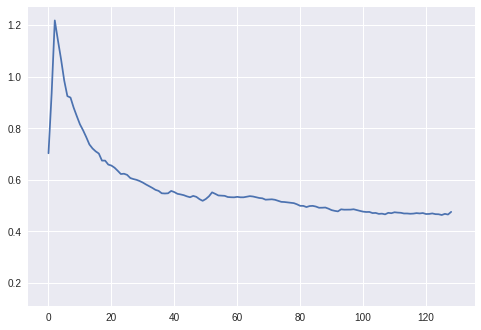

In [28]:
learn.recorder.plot_losses()

## 1cycle

We will now we build a 1cycle scheduler to train our network. To learn more about the 1cycle technique for training neural networks check out Leslie Smith's [paper](https://arxiv.org/pdf/1803.09820.pdf) and for a more graphical and intuitive explanation check out Sylvain Gugger's [post](https://sgugger.github.io/the-1cycle-policy.html).

We will first define some annealing functions as options to describe how to progressively move a parameter from a start value to an end value. We will also define a Stepper function that will apply our annealing function (default is linear) to our learning rate and momentum to get a learning rate and momentum value for each step in the training.

We will then build a callback that actually implements our one cycle policy and changes the parameters accordingly.

The one cycle policy has three steps:

1. We progressively increase our learning rate from *lr_max/div_factor* to *lr_max* and at the same time we progressively decrease our momentum from *mom_max* to *mom_min*.
2. We do the exact opposite: we progressively decrease our learning rate from *lr_max* to *lr_max/div_factor* and at the same time we progressively increase our momentum from *mom_min* to *mom_max*. 
3.  We further decrease our learning rate from *lr_max/div_factor* to *lr_max/(div_factor x  100)* and we keep momentum steady at *mom_max*.

We usually do steps 1 and 2 for an equal amount of iterations that together make ~90% of total iterations (in this case, we chose 45% each totalling 90%). The remaining iterations are used for step 3.

Note: 
Each of these transitions (i.e. how do we get from one value to another) is described by the annealing function of choice.

In [0]:
#export

AnnealFunc = Callable[[Number,Number,float], Number]
def annealing_no(start:Number, end:Number, pct:float)->Number: 
    "No annealing, always return `start`"
    return start
def annealing_linear(start:Number, end:Number, pct:float)->Number: 
    "Linearly anneal from `start` to `end` as pct goes from 0.0 to 1.0"
    return start + pct * (end-start)
def annealing_exp(start:Number, end:Number, pct:float)->Number: 
    "Exponentially anneal from `start` to `end` as pct goes from 0.0 to 1.0"
    return start * (end/start) ** pct
def annealing_cos(start:Number, end:Number, pct:float)->Number:
    "Cosine anneal from `start` to `end` as pct goes from 0.0 to 1.0"
    cos_out = np.cos(np.pi * pct) + 1
    return end + (start-end)/2 * cos_out
    
def do_annealing_poly(start:Number, end:Number, pct:float, degree:Number)->Number: 
    "Helper function for `anneal_poly`"
    return end + (start-end) * (1-pct)**degree
def annealing_poly(degree:Number)->Number: 
    "Anneal polynomically from `start` to `end` as pct goes from 0.0 to 1.0"
    return functools.partial(do_annealing_poly, degree=degree)

In [0]:
import functools

In [0]:
annealings = "NO LINEAR COS EXP POLY".split()

In [0]:
a = np.arange(0, 100)
p = np.linspace(0.01,1,100)

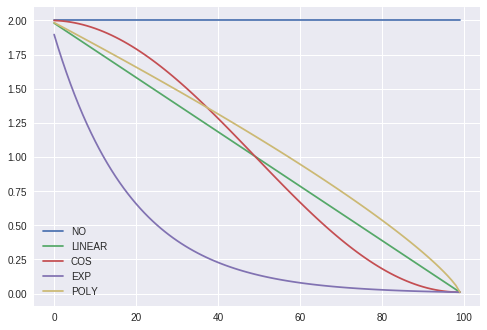

In [34]:
fns = [annealing_no, annealing_linear, annealing_cos, annealing_exp, annealing_poly(0.8)]
for fn, t in zip(fns, annealings):
    plt.plot(a, [fn(2, 1e-2, o) for o in p], label=t)
plt.legend();

In [0]:
#export
def is_tuple(x:Any)->bool: return isinstance(x, tuple)
StartOptEnd=Union[float,Tuple[float,float]]
class Stepper():
    "Used to \"step\" from start,end (`vals`) over `n_iter` iterations on a schedule defined by `func` (defaults to linear)"
    def __init__(self, vals:StartOptEnd, n_iter:int, func:Optional[AnnealFunc]=None):
        self.start,self.end = (vals[0],vals[1]) if is_tuple(vals) else (vals,0)
        self.n_iter = n_iter
        if func is None: self.func = annealing_linear if is_tuple(vals) else annealing_no
        else:          self.func = func
        self.n = 0
    
    def step(self)->Number:
        "Return next value along annealed schedule"
        self.n += 1
        return self.func(self.start, self.end, self.n/self.n_iter)
    
    @property
    def is_done(self)->bool:
        "Schedule completed"
        return self.n >= self.n_iter

In [0]:
#export
@dataclass
class OneCycleScheduler(Callback):
    "Manages 1-Cycle style traing as outlined in Leslie Smith's [paper](https://arxiv.org/pdf/1803.09820.pdf)"
    learn:Learner
    lr_max:float
    moms:Floats=(0.95,0.85)
    div_factor:float=25.
    pct_start:float=0.5
    
    def __post_init__(self): self.moms=tuple(listify(self.moms,2))

    def steps(self, *steps_cfg:StartOptEnd):
        "Build anneal schedule for all of the parameters"
        return [Stepper(step, n_iter, func=func)
                for (step,(n_iter,func)) in zip(steps_cfg, self.phases)]

    def on_train_begin(self, n_epochs:int, **kwargs:Any)->None:
        "Initialize our optimization params based on our annealing schedule"
        n = len(self.learn.data.train_dl) * n_epochs
        a1 = int(n * self.pct_start)
        a2 = n-a1
        self.phases = ((a1, annealing_linear), (a2, annealing_cos))
        low_lr = self.lr_max/self.div_factor
        self.lr_scheds = self.steps((low_lr, self.lr_max), (self.lr_max, low_lr/1e4))
        self.mom_scheds = self.steps(self.moms, (self.moms[1], self.moms[0]))
        self.opt = self.learn.opt
        self.opt.lr,self.opt.mom = self.lr_scheds[0].start,self.mom_scheds[0].start
        self.idx_s = 0
    
    def on_batch_end(self, **kwargs:Any)->None:
        "Take one step forward on the annealing schedule for the optim params"
        if self.idx_s >= len(self.lr_scheds): return Trrue
        self.opt.lr = self.lr_scheds[self.idx_s].step()
        self.opt.mom = self.mom_scheds[self.idx_s].step()
        # when the current schedule is complete we move onto the next 
        # schedule. (in 1-cycle there are two schedules)
        if self.lr_scheds[self.idx_s].is_done:
            self.idx_s += 1

def one_cycle_scheduler(lr_max:float, **kwargs:Any)->OneCycleScheduler:
    return partial(OneCycleScheduler, lr_max=lr_max, **kwargs)

In [0]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
sched = one_cycle_scheduler(0.1, pct_start=0.3, div_factor=5, moms=[0.95,0.85])
learn = Learner(data, model, metrics=metrics, callback_fns=sched)

In [38]:
learn.fit(1,0.1)

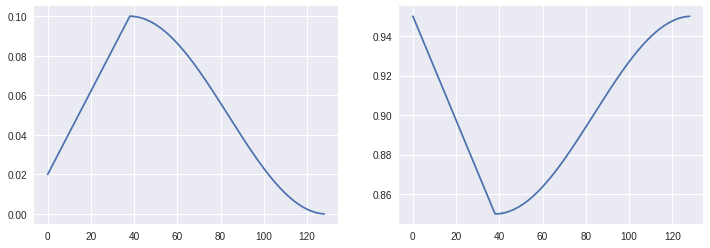

In [39]:
learn.recorder.plot_lr(show_moms=True)

In [0]:
#export
def fit_one_cycle(learn:Learner, cyc_len:int, max_lr:float, moms:Tuple[float,float]=(0.95,0.85),
                  div_factor:float=10., pct_start:float=0.5, wd:Optional[float]=None):
    "Fits a model following the 1cycle policy"
    cbs = [OneCycleScheduler(learn, max_lr, moms=moms, div_factor=div_factor,
                             pct_start=pct_start)]
    learn.fit(cyc_len, max_lr, wd=wd, callbacks=cbs)

In [41]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model, metrics=metrics)
fit_one_cycle(learn, 1, 0.1)

More generally, an API that allows you to create your own schedules.

In [0]:
#export
@dataclass
class TrainingPhase():
    "Schedule lr,mom according to `lr_anneal` and `mom_anneal` across a `length` schedule"
    length:int
    lrs:Floats
    moms:Floats
    lr_anneal:Callable=None
    mom_anneal:Callable=None
    
    def __post_init__(self)->None:
        self.lr_step = Stepper(lrs, length, lr_anneal)
        self.mom_step = Stepper(moms, length, mom_anneal)

@dataclass
class GeneralScheduler(Callback):
    "Schedule multiple `TrainingPhase` for a `learner`"
    learn:Learner
    phases:Collection[TrainingPhase]
    
    def on_train_begin(self, n_epochs:int, **kwargs:Any)->None:
        "Initialize our lr and mom schedules for training"
        self.lr_scheds = [p.lr_step for p in self.phases]
        self.mom_scheds = [p.mom_step for p in self.phases]
        self.opt = self.learn.opt
        self.opt.lr,self.opt.mom = self.lr_scheds[0].start,self.mom_scheds[0].start
        self.idx_s = 0
    
    def on_batch_end(self, **kwargs:Any)->None:
        "Take a step in lr,mom sched, start next sched when current is complete"
        if self.idx_s >= len(self.lr_scheds): return True
        self.opt.lr = self.lr_scheds[self.idx_s].step()
        self.opt.mom = self.mom_scheds[self.idx_s].step()
        if self.lr_scheds[self.idx_s].is_done:
            self.idx_s += 1

## LR Finder

In [0]:
#export
class LRFinder(LearnerCallback):
    "Explore lr vs loss relationship for a learner"
    def __init__(self, learn:Learner, start_lr:float=1e-5, end_lr:float=10, num_it:int=200)->None:
        "Initialize schedule of learning rates"
        super().__init__(learn)
        self.data = learn.data
        self.sched = Stepper((start_lr, end_lr), num_it, annealing_exp)
        #To avoid validating if the train_dl has less than num_it batches, we put aside the valid_dl and remove it
        #during the call to fit.
        self.valid_dl = learn.data.valid_dl
        self.data.valid_dl = None
    
    def on_train_begin(self, **kwargs:Any)->None:
        "init optimizer and learn params"
        self.learn.save('tmp')
        self.opt = self.learn.opt
        self.opt.lr = self.sched.start
        self.stop,self.best_loss = False,0.
    
    def on_batch_end(self, iteration:int, smooth_loss:TensorOrNumber, **kwargs:Any)->None:
        "Determine if loss has runaway and we should stop"
        if iteration==0 or smooth_loss < self.best_loss: self.best_loss = smooth_loss
        self.opt.lr = self.sched.step()
        if self.sched.is_done or smooth_loss > 4*self.best_loss:
            #We use the smoothed loss to decide on the stopping since it's less shaky.
            self.stop=True
            return True
    
    def on_epoch_end(self, **kwargs:Any)->None: 
        "Tell Learner if we need to stop"
        return self.stop
    
    def on_train_end(self, **kwargs:Any)->None:
        "Cleanup learn model weights disturbed during LRFind exploration"
        # restore the valid_dl we turned of on `__init__`
        self.data.valid_dl = self.valid_dl
        self.learn.load('tmp')

In [0]:
#export
def lr_find(learn:Learner, start_lr:float=1e-5, end_lr:float=10, num_it:int=100, **kwargs:Any):
    "Explore lr from `start_lr` to `end_lr` over `num_it` iterations of `learn`"
    cb = LRFinder(learn, start_lr, end_lr, num_it)
    a = int(np.ceil(num_it/len(learn.data.train_dl)))
    learn.fit(a, start_lr, callbacks=[cb], **kwargs)

In [0]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model, metrics=metrics)

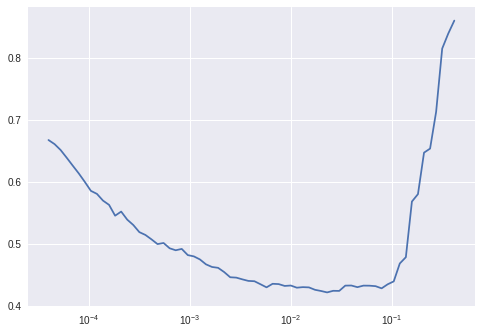

In [46]:
lr_find(learn)
learn.recorder.plot()

In [47]:
learn.fit(2, 5e-3, callbacks=OneCycleScheduler(learn, 0.1))

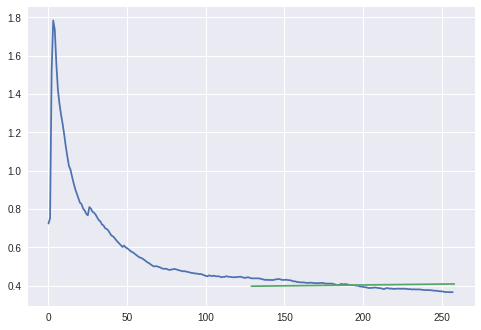

In [48]:
learn.recorder.plot_losses()

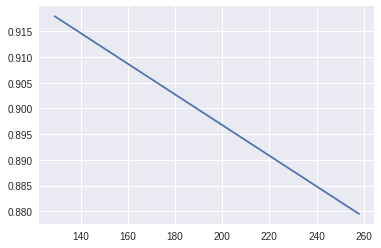

In [49]:
learn.recorder.plot_metrics()

## Show graph

In [0]:
#export
class ShowGraph(LearnerCallback):
    "Updates a graph of learner stats and metrics after each epoch"
    def on_epoch_end(self, n_epochs:int, last_metrics:MetricsList, **kwargs)->bool:
        "If we have metrics plot them in our pbar graph"
        if last_metrics is not None:
            rec = learn.recorder
            iters = list(range(len(rec.losses)))
            val_iter = np.array(rec.nb_batches).cumsum()
            x_bounds = (0, (n_epochs - len(rec.nb_batches)) * rec.nb_batches[-1] + len(rec.losses))
            y_bounds = (0, max((max(tensor(rec.losses)), max(tensor(rec.val_losses)))))
            rec.pbar.update_graph([(iters, rec.losses), (val_iter, rec.val_losses)], x_bounds, y_bounds) 
            return False

In [0]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model, metrics=metrics, callback_fns=ShowGraph)

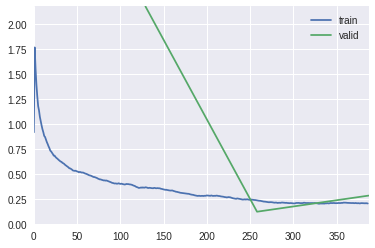

In [52]:
learn.fit(3, 5e-3)

## Eye of Sauron

To grasp the potential of callbacks, here's a full example:

In [0]:
class EyeOfSauron(Callback):

  def __init__(self, learn)->None:
  #By passing the learner, this callback will have access to everything:
  #All the inputs/outputs as they go, the losses, but also the data loaders, the optimizer.
    self.learn = learn

  #At any time:
  #Changing self.learn.data.train_dl or self.data.valid_dl will change them inside the fit function
  #(we just need to pass the data object to the fit function and not data.train_dl/data.valid_dl)
  #Changing self.learn.opt.opt (We have an HPOptimizer on top of the actual optimizer) will change it 
  #inside the fit function.
  #Changing self.learn.data or self.learn.opt directly WILL NOT change the data or the optimizer inside the fit function.

  #In any of the callbacks you can unpack in the kwargs:
  #- n_epochs, contains the number of epochs the training will take in total
  #- epoch, contains the number of the current
  #- iteration, contains the number of iterations done since the beginning of training
  #- num_batch, contains the number of the batch we're at in the dataloader
  #- last_input, contains the last input that got through the model (eventually updated by a callback)
  #- last_target, contains the last target that gor through the model (eventually updated by a callback)
  #- last_output, contains the last output spitted by the model (eventually updated by a callback)
  #- last_loss, contains the last loss computed (eventually updated by a callback)
  #- smooth_loss, contains the smoothed version of the loss
  #- last_metrics, contains the last validation loss and emtrics computed
  #- pbar, the progress bar

  def on_train_begin(self, **kwargs)->None:
  #Here we can initiliaze anything we need. 
    self.opt = self.learn.opt
  #The optimizer has now been initialized. We can change any hyper-parameters by typing
  #self.opt.lr = new_lr, self.opt.mom = new_mom, self.opt.wd = new_wd or self.opt.beta = new_beta

  def on_epoch_begin(self, **kwargs)->None:  pass
  #This is not technically useful since we have on_train_begin for epoch 0 and on_epoch_end for all the other epochs
  #yet it makes writing code that needs to be done at the beginning of every epoch easy and more readable.

  def on_batch_begin(self, **kwargs)->None: pass
  #Here is the perfect place to prepare everything before the model is called.
  #Example: change the values of the hyperparameters (if we don't do it on_batch_end instead)

  #If we return something, that will be the new value for xb,yb. 

  def on_loss_begin(self, **kwargs)->None: pass
  #Here is the place to run some code that needs to be executed after the output has been computed but before the
  #loss computation.
  #Example: putting the output back in FP32 when training in mixed precision.

  #If we return something, that will be the new value for the output.

  def on_backward_begin(self, **kwargs)->None: pass
  #Here is the place to run some code that needs to be executed after the loss has been computed but before the
  #gradient computation.
  #Example: reg_fn in RNNs.

  #If we return something, that will be the new value for loss. Since the recorder is always called first,
  #it will have the raw loss.

  def on_backward_end(self, **kwargs)->None: pass
  #Here is the place to run some code that needs to be executed after the gradients have been computed but
  #before the optimizer is called.
  #Example: deal with weight_decay in AdamW

  def on_step_end(self, **kwargs)->None: pass
  #Here is the place to run some code that needs to be executed after the optimizer step but before the gradients
  #are zeroed
  #Example: can't think of any that couldn't be done in on_batch_end but maybe someone will need this one day.

  def on_batch_end(self, **kwargs)->None: pass
  #Here is the place to run some code that needs to be executed after a batch is fully done.
  #Example: change the values of the hyperparameters (if we don't do it on_batch_begin instead)

  #If we return true, the current epoch is interrupted (example: lr_finder stops the training when the loss explodes)

  def on_epoch_end(self, **kwargs)->bool: return False
  #Here is the place to run some code that needs to be executed at the end of an epoch.
  #Example: Save the model if we have a new best validation loss/metric.

  #If we return true, the training stops (example: early stopping)

  def on_train_end(self, **kwargs)->None: pass
  #Here is the place to tidy everything. It's always executed even if there was an error during the training loop,
  #and has an extra kwarg named exception to check if there was an exception or not.
  #Examples: save log_files, load best model found during training

The idea is that one thing is entirely done in a callback so that it's easily read. By using this trick, we will have different methods categorized in different callbacks where we will find clearly stated all the interventions the method makes in training. For instance in the last LRFinder callback, on top of running the fit function with exponentially growing lrs, it needs to handle some preparation and clean-up, and all this code should be in the same callback so we know exactly what LRFinder is doing and where to look if we need to change something. 

## Tests for change of optimizers/dataloaders

Changing directly opt.opt or data.train_dl/data.valid_dl changes the corresponding item in the fit function.

In [0]:
data = DataBunch.create(train_ds, valid_ds, bs=bs, train_tfm=tfms, dl_tfms=cifar_norm)
data1 = DataBunch.create(train_ds, valid_ds, bs=32, train_tfm=tfms, dl_tfms=cifar_norm)

In [0]:
class CbTest():
    def __init__(self, learn, new_data):
        self.learn,self.new_data = learn,new_data
        
    def call_me(self):
        self.learn.data.train_dl = self.new_data.train_dl
        self.learn.data.valid_dl = self.new_data.valid_dl

In [0]:
learn.data = data

In [0]:
cb = CbTest(learn, data1)

In [0]:
def test(data, cb):
    x,y = next(iter(data.train_dl))
    print(x.size())
    cb.call_me()
    x,y = next(iter(data.train_dl))
    print(x.size())

In [63]:
test(learn.data, cb)

torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])


In [0]:
learn.opt = OptimWrapper(optim.SGD(model.parameters(), 1e-2))

In [0]:
class CbTest():
    def __init__(self, learn, new_opt): self.learn,self.new_opt = learn,new_opt
    def call_me(self): self.learn.opt.opt = self.new_opt

In [0]:
cb = CbTest(learn, optim.Adam)

In [0]:
def test(opt, cb):
    print(opt.opt)
    cb.call_me()
    print(opt.opt)

In [68]:
test(learn.opt,cb)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)
<class 'torch.optim.adam.Adam'>


Changing directly opt or data doesn't change anything inside the fit function.

In [0]:
data = DataBunch.create(train_ds, valid_ds, bs=bs, train_tfm=tfms, dl_tfms=cifar_norm)
data1 = DataBunch.create(train_ds, valid_ds, bs=32, train_tfm=tfms, dl_tfms=cifar_norm)

In [0]:
class CbTest():
    def __init__(self, learn, new_data): self.learn,self.new_data = learn,new_data
    def call_me(self): self.learn.data = self.new_data

In [0]:
learn.data = data

In [0]:
cb = CbTest(learn, data1)

In [0]:
def test(data, cb):
    x,y = next(iter(data.train_dl))
    print(x.size())
    cb.call_me()
    x,y = next(iter(data.train_dl))
    print(x.size())

In [86]:
test(learn.data, cb)

In [0]:
learn.opt = optim.SGD

In [0]:
class CbTest():
    def __init__(self, learn, new_opt): self.learn,self.new_opt = learn,new_opt
    def call_me(self): self.learn.opt = self.new_opt

In [0]:
cb = CbTest(learn, optim.Adam)

In [0]:
def test(opt, cb):
    print(opt)
    cb.call_me()
    print(opt)

In [85]:
test(learn.opt,cb)

<class 'torch.optim.sgd.SGD'>
<class 'torch.optim.sgd.SGD'>


## Fin